Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import random
from sklearn.metrics import f1_score, recall_score
import matplotlib.pyplot as plt
import os
import json

Device Configuration

In [2]:
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

device: cuda:0


Data Prep

In [3]:
# Download and load the CIFAR-100 dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_set = datasets.CIFAR100(root='../data', train=True, download=True, transform=transform)
test_set = datasets.CIFAR100(root='../data', train=False, download=True, transform=transform)

# Split train data into train and validation
train_size = int(0.8 * len(train_set))
val_size = len(train_set) - train_size
train_dataset, val_dataset = random_split(train_set, [train_size, val_size])

batch_size = 1024
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

100.0%


Extracting ../data\cifar-100-python.tar.gz to ../data
Files already downloaded and verified


Set Random Seed

In [4]:
# Function to set a random seed for reproducibility
def set_seed(seed=None):
    if seed is None:
        seed = np.random.randint(0, 10000)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    return seed

Validation

In [5]:
# Function for validation
def validate(net, val_loader, criterion):
    total_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    return total_loss / len(val_loader)

Calculate Test Error

In [6]:
# Function to calculate test error
def calculate_test_error(net, test_loader):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_accuracy = 100 * correct / total
    return 100 - test_accuracy  # Test error

Train Model

In [7]:
# Function for training
def train_model(net, train_loader, val_loader, test_loader, criterion, optimizer, epochs):
    train_losses = []
    val_losses = []
    test_errors = []
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        train_losses.append(running_loss / len(train_loader))
        val_loss = validate(net, val_loader, criterion)
        val_losses.append(val_loss)
        test_error = calculate_test_error(net, test_loader)
        test_errors.append(test_error)
        print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}, Test Error: {test_errors[-1]}')

    return train_losses, val_losses, test_errors

Metrics Calculation

In [8]:
# Function to calculate accuracy, F1 score, and recall
def calculate_metrics(net, loader):
    net.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for data in loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    return accuracy, f1, recall

Model Architecture

In [9]:
# ResNet-18 with SE block

# SE block
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)


def initialize_model(device):
    net = models.resnet18(weights=None)
    num_features = net.fc.in_features

    # Adding an SE block
    net.avgpool = nn.Sequential(net.avgpool, SEBlock(num_features))

    # Adjusting for 100 classes in CIFAR-100
    net.fc = torch.nn.Linear(num_features, 100)
    net = net.to(device)

    return net

Loss Function

In [10]:
def initialize_loss_function():
    return nn.CrossEntropyLoss()

Optimizer

In [11]:
def initialize_optimizer(model_params):
    return optim.SGD(model_params, lr=0.001)

Run

Run: 1
Seed: 2769
Epoch 1/200, Train Loss: 4.665564143657685, Validation Loss: 4.652097463607788, Test Error: 98.82
Epoch 2/200, Train Loss: 4.627648735046387, Validation Loss: 4.6175302028656, Test Error: 98.51
Epoch 3/200, Train Loss: 4.605813217163086, Validation Loss: 4.600675344467163, Test Error: 98.16
Epoch 4/200, Train Loss: 4.585800075531006, Validation Loss: 4.582944774627686, Test Error: 97.74
Epoch 5/200, Train Loss: 4.564610528945923, Validation Loss: 4.561540222167968, Test Error: 97.42
Epoch 6/200, Train Loss: 4.535914015769959, Validation Loss: 4.538395500183105, Test Error: 97.23
Epoch 7/200, Train Loss: 4.508201134204865, Validation Loss: 4.515480422973633, Test Error: 96.93
Epoch 8/200, Train Loss: 4.481220459938049, Validation Loss: 4.49378342628479, Test Error: 96.68
Epoch 9/200, Train Loss: 4.460611426830292, Validation Loss: 4.474080038070679, Test Error: 96.35
Epoch 10/200, Train Loss: 4.435990524291992, Validation Loss: 4.453859424591064, Test Error: 95.87
Epoc

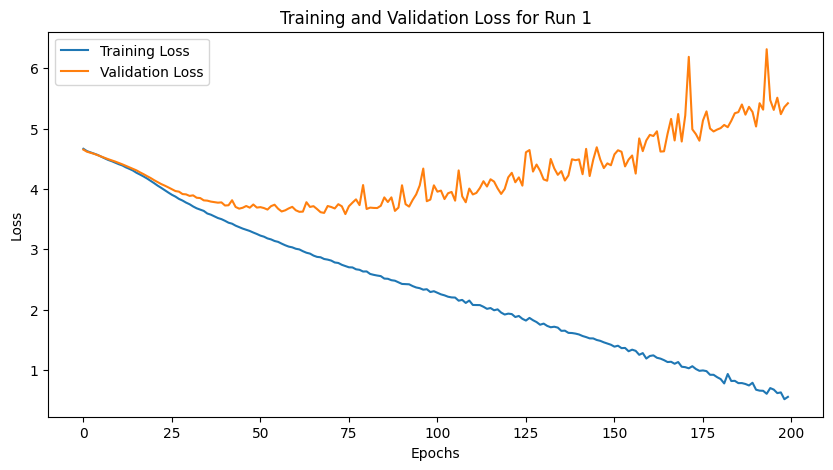

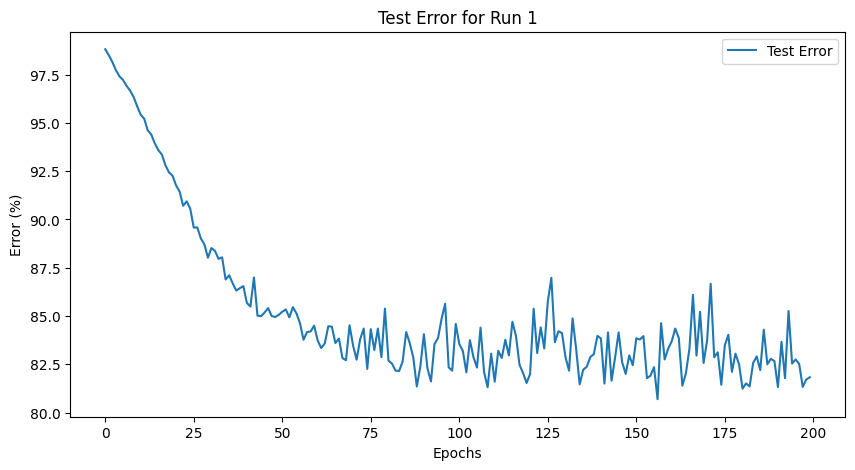

Run: 2
Seed: 4061
Epoch 1/200, Train Loss: 4.67052172422409, Validation Loss: 4.662200784683227, Test Error: 98.77
Epoch 2/200, Train Loss: 4.635810780525207, Validation Loss: 4.629048681259155, Test Error: 98.72
Epoch 3/200, Train Loss: 4.612221264839173, Validation Loss: 4.614862442016602, Test Error: 98.56
Epoch 4/200, Train Loss: 4.59461213350296, Validation Loss: 4.601072168350219, Test Error: 98.47
Epoch 5/200, Train Loss: 4.577010464668274, Validation Loss: 4.587423849105835, Test Error: 98.11
Epoch 6/200, Train Loss: 4.5582198858261105, Validation Loss: 4.5723895072937015, Test Error: 97.73
Epoch 7/200, Train Loss: 4.5381805300712585, Validation Loss: 4.553581714630127, Test Error: 97.53
Epoch 8/200, Train Loss: 4.517026436328888, Validation Loss: 4.534894323348999, Test Error: 97.14
Epoch 9/200, Train Loss: 4.490511786937714, Validation Loss: 4.512241840362549, Test Error: 96.9
Epoch 10/200, Train Loss: 4.464276444911957, Validation Loss: 4.485469102859497, Test Error: 96.52
E

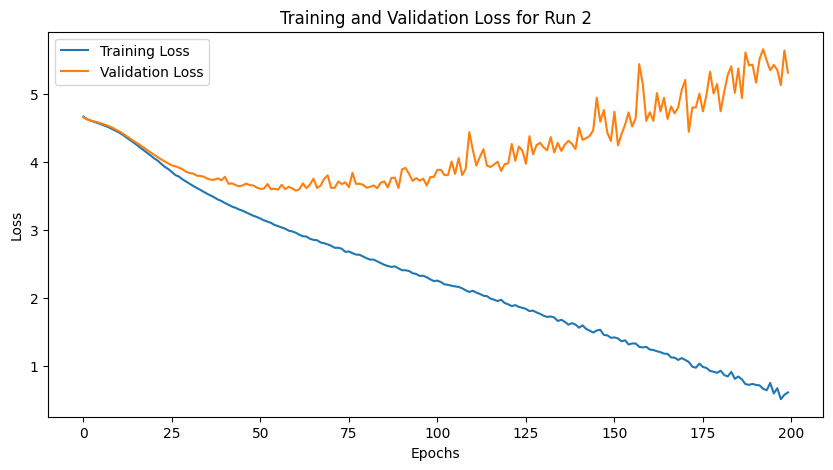

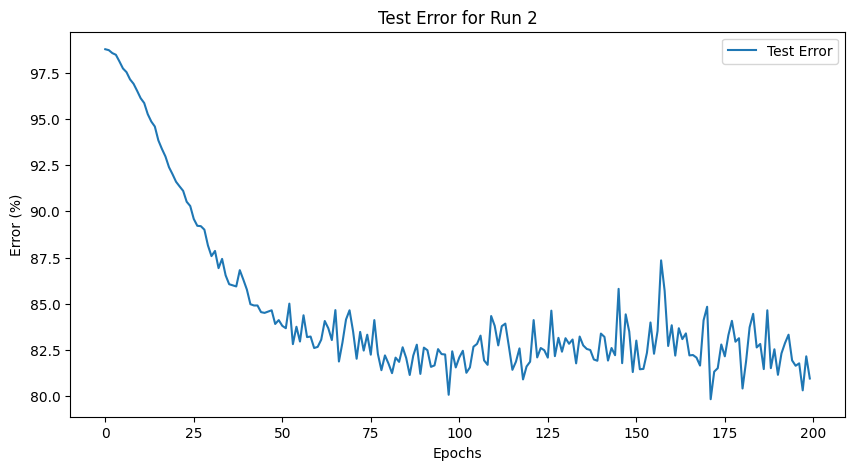

Run: 3
Seed: 1245
Epoch 1/200, Train Loss: 4.6595090389251705, Validation Loss: 4.660745143890381, Test Error: 98.93
Epoch 2/200, Train Loss: 4.631010937690735, Validation Loss: 4.631605195999145, Test Error: 98.92
Epoch 3/200, Train Loss: 4.612710082530976, Validation Loss: 4.619273233413696, Test Error: 98.77
Epoch 4/200, Train Loss: 4.596643841266632, Validation Loss: 4.607295942306519, Test Error: 98.49
Epoch 5/200, Train Loss: 4.581845450401306, Validation Loss: 4.595133972167969, Test Error: 98.21
Epoch 6/200, Train Loss: 4.565335071086883, Validation Loss: 4.584980916976929, Test Error: 98.05
Epoch 7/200, Train Loss: 4.551655697822571, Validation Loss: 4.57138090133667, Test Error: 97.73
Epoch 8/200, Train Loss: 4.534957754611969, Validation Loss: 4.556247138977051, Test Error: 97.33
Epoch 9/200, Train Loss: 4.5174234986305235, Validation Loss: 4.538689279556275, Test Error: 96.92
Epoch 10/200, Train Loss: 4.498073613643646, Validation Loss: 4.5185182094573975, Test Error: 96.49

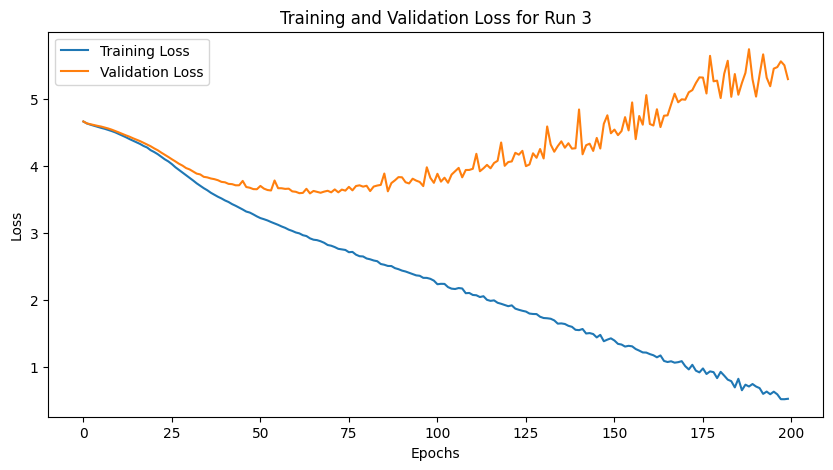

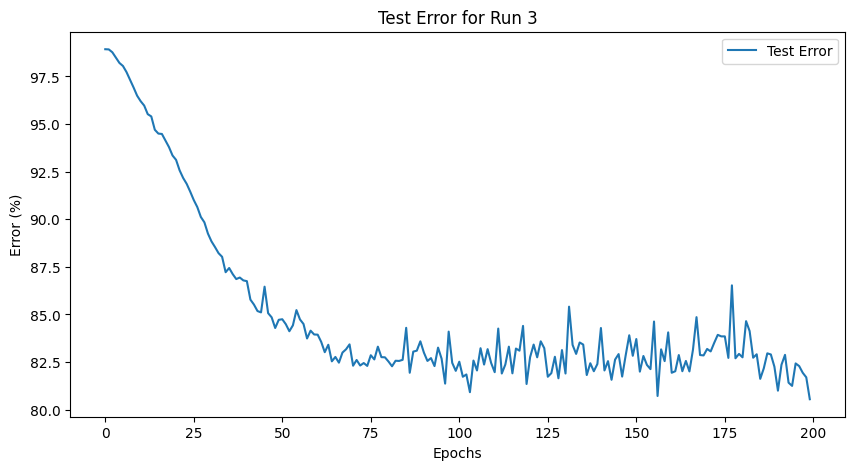

Run: 4
Seed: 2150
Epoch 1/200, Train Loss: 4.673380517959595, Validation Loss: 4.66703085899353, Test Error: 98.91
Epoch 2/200, Train Loss: 4.638768827915191, Validation Loss: 4.6370807647705075, Test Error: 98.85
Epoch 3/200, Train Loss: 4.619783568382263, Validation Loss: 4.623787355422974, Test Error: 98.7
Epoch 4/200, Train Loss: 4.606748175621033, Validation Loss: 4.614290952682495, Test Error: 98.52
Epoch 5/200, Train Loss: 4.59119815826416, Validation Loss: 4.602434587478638, Test Error: 98.15
Epoch 6/200, Train Loss: 4.578638100624085, Validation Loss: 4.594401264190674, Test Error: 98.25
Epoch 7/200, Train Loss: 4.565629661083221, Validation Loss: 4.583050012588501, Test Error: 98.06
Epoch 8/200, Train Loss: 4.55282232761383, Validation Loss: 4.5724729061126705, Test Error: 97.79
Epoch 9/200, Train Loss: 4.537458109855652, Validation Loss: 4.561486864089966, Test Error: 97.63
Epoch 10/200, Train Loss: 4.52342289686203, Validation Loss: 4.547738361358642, Test Error: 97.37
Epoc

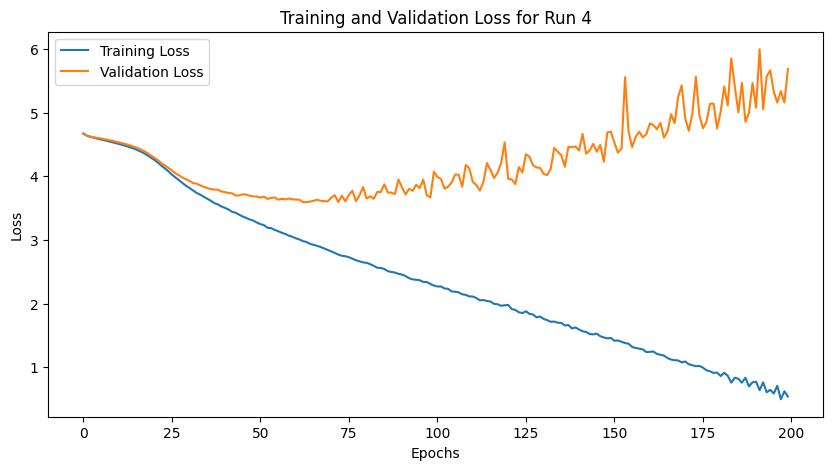

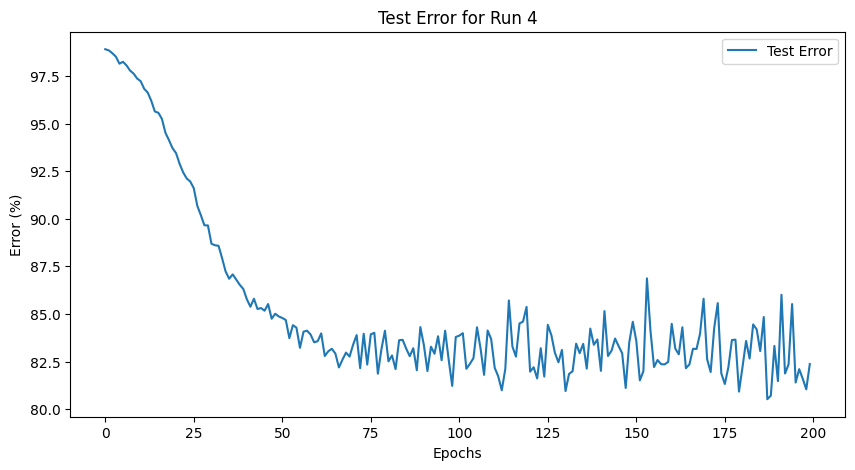

Run: 5
Seed: 2329
Epoch 1/200, Train Loss: 4.677721130847931, Validation Loss: 4.662275695800782, Test Error: 98.98
Epoch 2/200, Train Loss: 4.635796463489532, Validation Loss: 4.622433757781982, Test Error: 98.74
Epoch 3/200, Train Loss: 4.616987538337708, Validation Loss: 4.610807847976685, Test Error: 98.73
Epoch 4/200, Train Loss: 4.600209641456604, Validation Loss: 4.602091598510742, Test Error: 98.65
Epoch 5/200, Train Loss: 4.588258814811707, Validation Loss: 4.593552684783935, Test Error: 98.6
Epoch 6/200, Train Loss: 4.5760805130004885, Validation Loss: 4.583366966247558, Test Error: 98.26
Epoch 7/200, Train Loss: 4.563085126876831, Validation Loss: 4.57351016998291, Test Error: 98.01
Epoch 8/200, Train Loss: 4.549312281608581, Validation Loss: 4.563989734649658, Test Error: 97.7
Epoch 9/200, Train Loss: 4.535192692279816, Validation Loss: 4.550558805465698, Test Error: 97.36
Epoch 10/200, Train Loss: 4.521407496929169, Validation Loss: 4.536747646331787, Test Error: 97.11
Epo

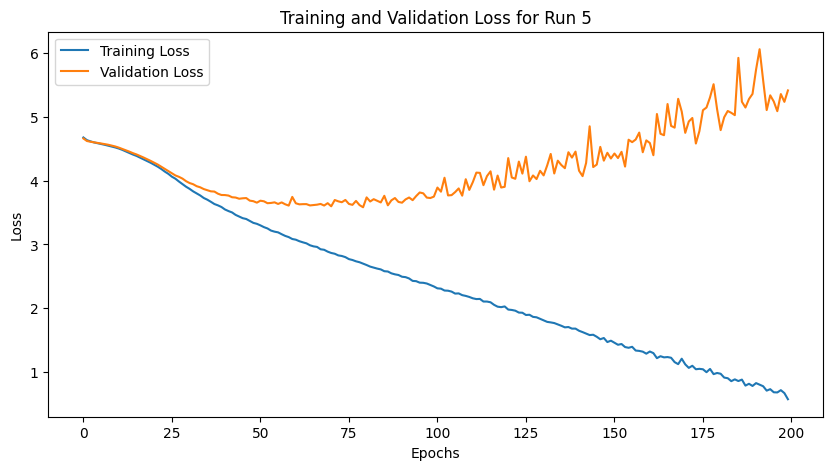

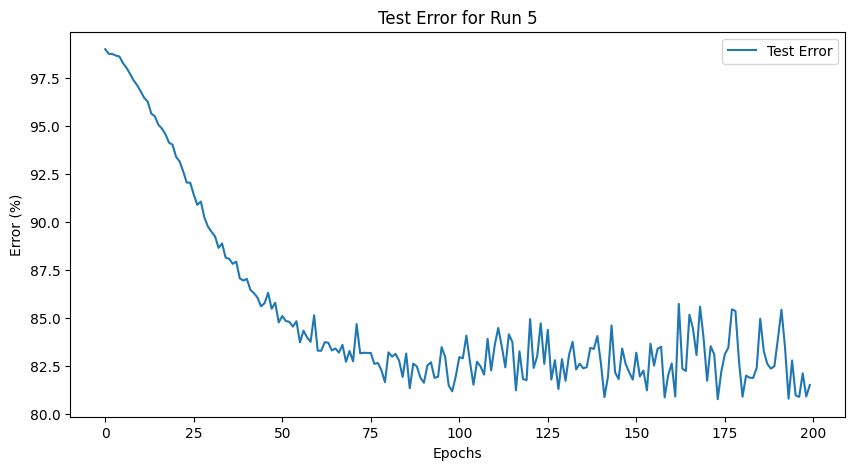

In [12]:
# Run the training for 5 different seeds
num_runs = 5
epochs = 200
metrics = {
    'seed': [],
    'train_losses': [],
    'val_losses': [],
    'test_errors': [],
    'val_accuracy': [],
    'val_f1': [],
    'val_recall': [],
    'test_accuracy': [],
    'test_f1': [],
    'test_recall': []
}



# Initialize dictionaries to store results
results = {
    'train_losses': [],
    'val_losses': [],
    'test_errors': []
}

for run in range(num_runs):
    print(f"Run: {run + 1}")
    seed = set_seed()
    print(f"Seed: {seed}")

    # Reinitialize the model, loss function, and optimizer
    net = initialize_model(device=device)
    criterion = initialize_loss_function()
    optimizer = initialize_optimizer(model_params=net.parameters())

    # Train the network
    train_losses, val_losses, test_errors = train_model(net, train_loader, val_loader, test_loader, criterion, optimizer, epochs)
    metrics['test_errors'].append(test_errors)

    # Calculate metrics on validation and test sets
    val_accuracy, val_f1, val_recall = calculate_metrics(net, val_loader)
    test_accuracy, test_f1, test_recall = calculate_metrics(net, test_loader)
    
    # Print metrics for validation set
    print(f"Run {run + 1} - Validation Metrics:")
    print(f"    Accuracy: {val_accuracy}%")
    print(f"    F1 Score: {val_f1}")
    print(f"    Recall:   {val_recall}")

    # Print metrics for test set
    print(f"Run {run + 1} - Test Metrics:")
    print(f"    Accuracy: {test_accuracy}%")
    print(f"    F1 Score: {test_f1}")
    print(f"    Recall:   {test_recall}")
    
    # Store metrics
    metrics['seed'].append(seed)
    metrics['train_losses'].append(train_losses)
    metrics['val_losses'].append(val_losses)
    metrics['val_accuracy'].append(val_accuracy)
    metrics['val_f1'].append(val_f1)
    metrics['val_recall'].append(val_recall)
    metrics['test_accuracy'].append(test_accuracy)
    metrics['test_f1'].append(test_f1)
    metrics['test_recall'].append(test_recall)
    
    # Append the results for the current run
    results['train_losses'].append(metrics['train_losses'][run])
    results['val_losses'].append(metrics['val_losses'][run])
    results['test_errors'].append(metrics['test_errors'][run])

    # Plot for training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(metrics['train_losses'][run], label='Training Loss')
    plt.plot(metrics['val_losses'][run], label='Validation Loss')
    plt.title(f"Training and Validation Loss for Run {run+1}")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot for test error
    plt.figure(figsize=(10, 5))
    plt.plot(metrics['test_errors'][run], label='Test Error')
    plt.title(f"Test Error for Run {run+1}")
    plt.xlabel('Epochs')
    plt.ylabel('Error (%)')
    plt.legend()
    plt.show()

Metrics Calculation and Plotting Mean Test Error

Mean Metrics: {'val_accuracy': 19.003999999999998, 'val_f1': 0.1877011124593846, 'val_recall': 0.19004000000000001, 'test_accuracy': 18.558, 'test_f1': 0.18286599543763046, 'test_recall': 0.18558}
Standard Deviation of Metrics: {'val_accuracy': 0.671255540014382, 'val_f1': 0.007703652321079261, 'val_recall': 0.0067125554001438255, 'test_accuracy': 0.6392307877441447, 'test_f1': 0.00799215245960881, 'test_recall': 0.006392307877441449}


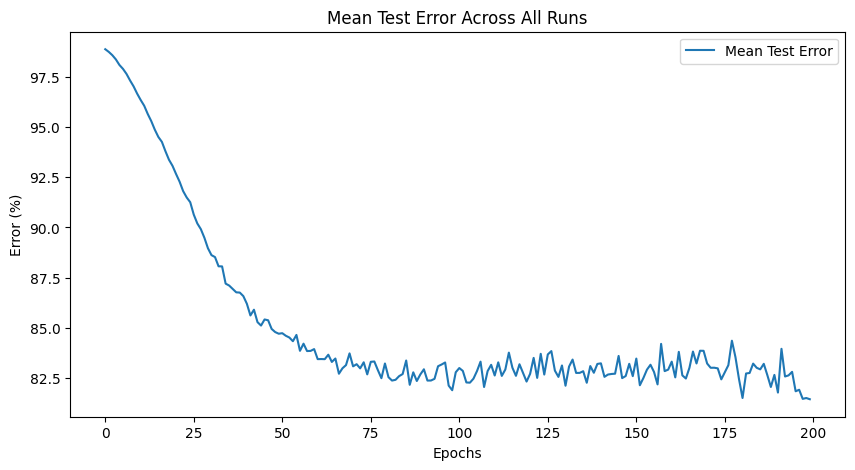

In [13]:
# Calculate mean and standard deviation across runs
mean_metrics = {metric: np.mean(metrics[metric]) for metric in metrics if metric not in ['seed', 'train_losses', 'val_losses', 'test_errors']}
std_metrics = {metric: np.std(metrics[metric]) for metric in metrics if metric not in ['seed', 'train_losses', 'val_losses', 'test_errors']}

# Print mean metrics and standard deviation
print("Mean Metrics:", mean_metrics)
print("Standard Deviation of Metrics:", std_metrics)

# Calculate mean test error across all runs
mean_test_errors = np.mean(metrics['test_errors'], axis=0)

# Plot mean test error
plt.figure(figsize=(10, 5))
plt.plot(mean_test_errors, label='Mean Test Error')
plt.title("Mean Test Error Across All Runs")
plt.xlabel('Epochs')
plt.ylabel('Error (%)')
plt.legend()
plt.show()

Save data

In [14]:
# Directory for saving results
save_dir = 'CIFAR_100_RN18_AL_Results'
os.makedirs(save_dir, exist_ok=True)

# Save the results to a file
with open(os.path.join(save_dir, 'SGD.json'), 'w') as f:
    json.dump(results, f)